## TODO
* add time-performance tests
* remove as_strided from preprocessing, because it's very unstable
* concat real time signal with old data, because CREPE uses big 1d convolutions (512 len), and it needs data from left side

In [1]:
from typing import Optional, List

import os
import re
import sys
import time
import datetime

from scipy.io import wavfile
import numpy as np
from numpy.lib.stride_tricks import as_strided

import sounddevice as sd

%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation

from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense
from tensorflow.keras.models import Model


2021-08-11 21:52:08.792657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-11 21:52:08.792678: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
MODEL_SR = 16000
USE_CENTER_PAD = True

# CALLS_PER_SEC = 2  # TODO: increase to 10-20 (should be smooth)
# BLOCK_SIZE = MODEL_SR // CALLS_PER_SEC
BLOCK_SIZE = 1024


In [43]:
mpl.rcsetup.all_backends

['GTK3Agg',
 'GTK3Cairo',
 'MacOSX',
 'nbAgg',
 'Qt4Agg',
 'Qt4Cairo',
 'Qt5Agg',
 'Qt5Cairo',
 'TkAgg',
 'TkCairo',
 'WebAgg',
 'WX',
 'WXAgg',
 'WXCairo',
 'agg',
 'cairo',
 'pdf',
 'pgf',
 'ps',
 'svg',
 'template']

In [44]:
mpl.use("Qt5Agg")

In [45]:
def build_and_load_model(model_capacity, filename):
    """
    Build the CNN model and load the weights
    Parameters
    ----------
    model_capacity : 'tiny', 'small', 'medium', 'large', or 'full'
        String specifying the model capacity, which determines the model's
        capacity multiplier to 4 (tiny), 8 (small), 16 (medium), 24 (large),
        or 32 (full). 'full' uses the model size specified in the paper,
        and the others use a reduced number of filters in each convolutional
        layer, resulting in a smaller model that is faster to evaluate at the
        cost of slightly reduced pitch estimation accuracy.
    Returns
    -------
    model : tensorflow.keras.models.Model
        The pre-trained keras model loaded in memory
    """

    capacity_multiplier = {
        'tiny': 4, 'small': 8, 'medium': 16, 'large': 24, 'full': 32
    }[model_capacity]

    layers = [1, 2, 3, 4, 5, 6]
    filters = [n * capacity_multiplier for n in [32, 4, 4, 4, 8, 16]]
    widths = [512, 64, 64, 64, 64, 64]
    strides = [(4, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]

    x = Input(shape=(1024,), name='input', dtype='float32')
    y = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(x)

    for l, f, w, s in zip(layers, filters, widths, strides):
        y = Conv2D(f, (w, 1), strides=s, padding='same',
                   activation='relu', name="conv%d" % l)(y)
        y = BatchNormalization(name="conv%d-BN" % l)(y)
        y = MaxPool2D(pool_size=(2, 1), strides=None, padding='valid',
                      name="conv%d-maxpool" % l)(y)
        y = Dropout(0.25, name="conv%d-dropout" % l)(y)

    y = Permute((2, 1, 3), name="transpose")(y)
    y = Flatten(name="flatten")(y)
    y = Dense(360, activation='sigmoid', name="classifier")(y)

    model = Model(inputs=x, outputs=y)

    model.load_weights(filename)
    model.compile('adam', 'binary_crossentropy')

    return model

In [46]:
model = build_and_load_model("tiny", "../models/model-tiny.h5")

In [47]:
# class DynamicLinePlotter:
#     def __init__(self, n_points: int, fig_kwargs: Optional[dict] = None):
#         plt.ion()
#         self.n_points = n_points
#         self.points = []
        
#         if fig_kwargs is None:
#             fig_kwargs = {}
            
#         self.fig = plt.figure(**fig_kwargs)
#         ax = self.fig.add_subplot(111)
#         self.line, = ax.plot(range(n_points), [0] * n_points)
#         self.fig.show()
#         plt.show()

#     def add(self, values: List[float]):
#         self.points += values
        
#     def update_plot(self):
#         if len(self.points) >= self.n_points:
#             self.line.set_ydata(self.points[-self.n_points:])

#             self.fig.canvas.draw()
#             self.fig.canvas.flush_events()
#             print("updating plot")
#             self.fig.show()
#             plt.show()

In [48]:
stream = sd.InputStream(
                samplerate=MODEL_SR,
                blocksize = 1024,
                channels = 1,
)

In [49]:
calls_idx = 0


def detect_pitch(signal):
    start_time = time.time()
    global dynamic_line_plotter
    global calls_idx
    
#     calls_idx += 1
#     if calls_idx % 4 == 0:
#         return
#     print(datetime.datetime.now())
    
    # make 1024-sample frames of the audio with hop length of 10 milliseconds
#     step_size = 10
#     hop_length = int(MODEL_SR * step_size / 1000)
#     n_frames = 1 + int((len(signal) - 1024) / hop_length)
    
#     split_idxs = np.arange(1024, len(signal), 1024)
#     frames = np.split(signal, split_idxs)

#     last = frames[-1]
        
#     if len(frames[-1]) < 1024:
#         need_to_pad = 1024 - len(frames[-1])
#         right_zeros = need_to_pad // 2
#         left_zeros = need_to_pad - right_zeros
        
#         frames[-1] = np.concatenate([np.zeros((left_zeros, 1)), frames[-1], np.zeros((right_zeros, 1))])
    frames = signal[:1024].reshape(1, -1)
#     frames = np.concatenate(frames, axis=1)

    

    # normalize each frame -- this is expected by the model
    frames -= np.mean(frames, axis=1)[:, np.newaxis]
    frames /= np.std(frames, axis=1)[:, np.newaxis]
    
    model_preds = model(frames, training=False)#, workers=-1, use_multiprocessing=True)
    model_preds = model_preds.numpy()
#     print("time needed", time.time() - start_time)
    batch_pitch = model_preds.argmax(axis=1)
    confidence = model_preds.max(axis=1)
    
    return batch_pitch, confidence

In [ ]:
RECORD_SECONDS = 300
stream.start()

plt.ylim((60, 300))

n_points = 200
points = []

fig, ax = plt.subplots()

# animated=True tells matplotlib to only draw the artist when we
# explicitly request it
(plotted_data,) = ax.plot(range(n_points), [60] * 100 + [300] * 100, animated=True)
plt.show(block=False)
plt.pause(0.1)

bg = fig.canvas.copy_from_bbox(fig.bbox)
# draw the animated artist, this uses a cached renderer
ax.draw_artist(plotted_data)
# show the result to the screen, this pushes the updated RGBA buffer from the
# renderer to the GUI framework so you can see it
fig.canvas.blit(fig.bbox)


for block_idx in range(0, int(MODEL_SR / BLOCK_SIZE * RECORD_SECONDS)):
    audio_arr, is_overflowed = stream.read(BLOCK_SIZE)
#     if block_idx % 2 == 0:
    if True:
        if is_overflowed:
            raise OverflowError()

        model_preds, confidence = detect_pitch(audio_arr)
        model_preds = model_preds.astype(np.float32)
        model_preds[confidence < 0.5] = None
        points += list(model_preds)

    else:
        points.append(np.nan)
        
    if len(points) >= n_points and len(points) % 1 == 0:
        print("beb", indexes[not_nan_mask], new_plot_data[not_nan_mask])
#         display.clear_output(wait=True)
#         plt.clf()
    
        fig.canvas.restore_region(bg)

#         plt.scatter(range(n_points), points[-1 * n_points:])
        
        new_plot_data = np.array(points[-1 * n_points:])
        not_nan_mask = np.logical_not(np.isnan(new_plot_data))
        indexes = np.arange(len(new_plot_data))
#         plotted_data.set_data(indexes[not_nan_mask], new_plot_data[not_nan_mask])
        plotted_data.set_data(indexes, new_plot_data)
#         plt.draw()
#         plt.pause(1e-17)

        ax.draw_artist(plotted_data)
        fig.canvas.blit(fig.bbox)
        fig.canvas.flush_events()

#         display.display(plt.gcf())
    
stream.stop()

beb [  0   4   5   6   7   9  11  12  14  17  79 128] [181. 111. 103.  96.  91.  87.  88. 226.  82.  85. 181. 185.]
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [] []
beb [199] [108.]
beb [198 199] [108. 108.]
beb [197 198 199] [108. 108. 106.]
beb [196 197 198] [108. 108. 106.]
beb [195 196 197] [108. 108. 106.]
beb [194 195 196] [108. 108. 106.]
beb [193 194 195] [108. 108. 106.]
beb [192 193 194 199] [108. 108. 106.  83.]
beb [191 192 193 198 199] [108. 108. 106.  83.  82.]
beb [190 191 192 197 198] [108. 108. 106.  83.  82.]
beb [189 190 191 196 197] [108. 108. 106.  83.  82.]
beb [188 189 190 195 196] [108. 108. 106.  83.  82.]
beb [187 188 189 194 195] [108. 108. 106.  83.  82.]
beb [186 187 188 193 194 199] [108. 108. 106.  83.  82. 103.]
beb [185 186 187 192 193 198 199] [108. 108. 106.  83.  82. 103. 

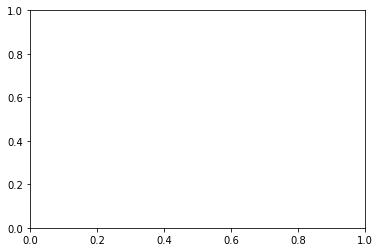

In [82]:
import matplotlib.pyplot as plt
import numpy as np


x = np.linspace(0, 2 * np.pi, 200)

fig, ax = plt.subplots()

# animated=True tells matplotlib to only draw the artist when we
# explicitly request it
(ln,) = ax.plot(np.arange(200), [-1] * 200, animated=True)

# make sure the window is raised, but the script keeps going
plt.show(block=False)

# stop to admire our empty window axes and ensure it is rendered at
# least once.
#
# We need to fully draw the figure at its final size on the screen
# before we continue on so that :
#  a) we have the correctly sized and drawn background to grab
#  b) we have a cached renderer so that ``ax.draw_artist`` works
# so we spin the event loop to let the backend process any pending operations
plt.pause(0.1)

# get copy of entire figure (everything inside fig.bbox) sans animated artist
bg = fig.canvas.copy_from_bbox(fig.bbox)
# draw the animated artist, this uses a cached renderer
ax.draw_artist(ln)
# show the result to the screen, this pushes the updated RGBA buffer from the
# renderer to the GUI framework so you can see it
fig.canvas.blit(fig.bbox)

points = []

for j in range(0, int(MODEL_SR / BLOCK_SIZE * RECORD_SECONDS)):
#     audio_arr, is_overflowed = stream.read(BLOCK_SIZE)
#     if block_idx % 2 == 0:
#     if True:
#         if is_overflowed:
#             raise OverflowError()

#         model_preds, confidence = detect_pitch(audio_arr)
#         model_preds = model_preds.astype(np.float32)
#         model_preds[confidence < 0.4] = None
#         points += list(model_preds)

#     else:
#         points.append(np.nan)
        
    # reset the background back in the canvas state, screen unchanged
    fig.canvas.restore_region(bg)
    # update the artist, neither the canvas state nor the screen have changed
    
        
#     new_plot_data = np.array(points[-1 * n_points:])
#     not_nan_mask = np.logical_not(np.isnan(new_plot_data))
#     indexes = np.arange(len(new_plot_data))
#     print(new_plot_data[not_nan_mask])
#     ln.set_data(indexes[not_nan_mask], new_plot_data[not_nan_mask])
        
    ln.set_ydata(np.sin(x + (j / 100) * np.pi))
    # re-render the artist, updating the canvas state, but not the screen
    ax.draw_artist(ln)
    # copy the image to the GUI state, but screen might not be changed yet
    fig.canvas.blit(fig.bbox)
    # flush any pending GUI events, re-painting the screen if needed
    fig.canvas.flush_events()
    # you can put a pause in if you want to slow things down

In [54]:
# import pyaudio
# from math import ceil

# # TODO: debug format affects
# FORMAT = pyaudio.paFloat32
# # FORMAT = pyaudio.paFloat64
# CHANNELS = 1
# RATE = MODEL_SR
# CHUNK = 1024
# RECORD_SECONDS = 20
 
# audio = pyaudio.PyAudio()
 
# # start Recording
# stream = audio.open(format=FORMAT, 
#                     channels=CHANNELS,
#                     rate=RATE, 
#                     input=True,
#                     frames_per_buffer=CHUNK
#                    )

# print("start recording")
# for i in range(0, ceil(RATE / CHUNK * RECORD_SECONDS)):
#     audio_chunk = stream.read(CHUNK)
#     arr = np.frombuffer(audio_chunk)
#     print(type(arr), arr.shape, arr[:10])
    
#     raise ValueError()
    
# print("finished recording")
 
# # stop Recording
# stream.stop_stream()
# stream.close()
# audio.terminate()

In [ ]:
plt.plot(accum_pitches)

In [ ]:
sd.query_devices()